In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# === STAGE 2: LABEL → IMAGE RETRIEVAL PIPELINE ===

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
from pathlib import Path
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# === CONFIG ===
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR = Path("/content/drive/MyDrive/Deep Learning Project Group")
CSV_PATH = BASE_DIR / "CheXRetriever/data/test/test_metadata_merged.csv"
IMAGE_ROOT = BASE_DIR / "CheXRetriever/data"
LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Enlarged Cardiomediastinum",
    "Fracture", "Lung Lesion", "Lung Opacity", "No Finding", "Pleural Effusion",
    "Pleural Other", "Pneumonia", "Pneumothorax", "Support Devices"
]
NUM_CLASSES = len(LABELS)
IMAGE_SIZE = 224

In [ ]:
# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)
df["split"] = "test"
df["filename"] = df["path_to_image"].apply(lambda x: "_".join(x.split("/")).replace(".jpg", ".png"))
df[LABELS] = df[LABELS].fillna(0).replace(-1, 0).astype(int)
df.reset_index(drop=True, inplace=True)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

class CheXpertEvalDataset(Dataset):
    def __init__(self, dataframe, image_root, transform):
        self.df = dataframe
        self.image_root = image_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = self.image_root / row["split"] / "images" / row["filename"]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        labels = torch.tensor(row[LABELS].values.astype(np.float32))
        return image, labels, row["filename"], row["path_to_image"]

# === LOAD MODEL ===
class ResNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        base = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.encoder = nn.Sequential(*list(base.children())[:-1])
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(2048, NUM_CLASSES)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.classifier(x)

model = ResNetClassifier().to(DEVICE)
model.load_state_dict(torch.load(BASE_DIR / "resnet_model/best_resnet_finetuned.pt"))
model.eval()

# === INFERENCE ===
dataset = CheXpertEvalDataset(df, IMAGE_ROOT, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())

all_probs, all_preds, all_filenames, all_paths = [], [], [], []

with torch.no_grad():
    for images, _, fnames, paths in tqdm(dataloader, desc="Running inference"):
        images = images.to(DEVICE)
        logits = model(images)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)
        all_filenames.extend(fnames)
        all_paths.extend(paths)

all_probs = np.vstack(all_probs)
all_preds = np.vstack(all_preds)

# === SAVE PREDICTIONS TO CSV ===
for i, label in enumerate(LABELS):
    df[f"prob_{label}"] = all_probs[:, i]
    df[f"pred_{label}"] = all_preds[:, i]

output_path = BASE_DIR / "resnet_model/label_to_image_inference_results.csv"
df.to_csv(output_path, index=False)
print(f"✅ Predictions saved to: {output_path}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 234MB/s]
Running inference: 100%|██████████| 138/138 [04:59<00:00,  2.17s/it]


✅ Predictions saved to: /content/drive/MyDrive/Deep Learning Project Group/resnet_model/label_to_image_inference_results.csv


In [ ]:
def retrieve_top_k_images(query_labels, image_df, k=5):
    image_vectors = image_df[[f"pred_{label}" for label in LABELS]].values
    sims = cosine_similarity([query_labels], image_vectors)[0]
    top_k_indices = sims.argsort()[::-1][:k]
    return image_df.iloc[top_k_indices][["path_to_image"] + [f"pred_{lbl}" for lbl in LABELS]]

In [ ]:
# Example: Cardiomegaly + Edema
query = np.array([0, 1, 0, 1] + [0] * 10)
df_preds = pd.read_csv(output_path)

top_matches = retrieve_top_k_images(query, df_preds, k=5)
top_matches

,path_to_image,pred_Atelectasis,pred_Cardiomegaly,pred_Consolidation,pred_Edema,pred_Enlarged Cardiomediastinum,pred_Fracture,pred_Lung Lesion,pred_Lung Opacity,pred_No Finding,pred_Pleural Effusion,pred_Pleural Other,pred_Pneumonia,pred_Pneumothorax,pred_Support Devices
3191,train/patient19407/study1/view1_frontal.jpg,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3155,train/patient34546/study6/view1_frontal.jpg,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2107,train/patient02315/study1/view2_frontal.jpg,0,1,0,0,0,0,0,0,0,0,0,0,0,1
422,train/patient28432/study5/view1_frontal.jpg,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2891,train/patient33809/study2/view1_frontal.jpg,0,1,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
from sklearn.metrics import average_precision_score

def evaluate_retrieval(df, k=5):
    true_vectors = df[LABELS].values
    pred_vectors = df[[f"pred_{lbl}" for lbl in LABELS]].values
    total = len(df)

    recall_at_k, mean_iou, map_scores = 0, [], []

    for i in tqdm(range(total), desc=f"Evaluating Top-{k} Retrieval"):
        query = true_vectors[i]
        image_vectors = pred_vectors
        sims = cosine_similarity([query], image_vectors)[0]
        top_k_indices = sims.argsort()[::-1][:k]

        # Recall@K: does any retrieved sample match the true vector exactly?
        retrieved = true_vectors[top_k_indices]
        recall_hit = any(np.array_equal(query, r) for r in retrieved)
        recall_at_k += recall_hit

        # mAP@K (approx): treat similarity scores as predictions
        binary_relevance = (true_vectors == query).all(axis=1).astype(int)
        map_score = average_precision_score(binary_relevance, sims)
        map_scores.append(map_score)

        # Mean IOU
        for idx in top_k_indices:
            intersection = np.sum(np.logical_and(query, true_vectors[idx]))
            union = np.sum(np.logical_or(query, true_vectors[idx])) + 1e-8
            mean_iou.append(intersection / union)

    recall_at_k /= total
    map_at_k = np.mean(map_scores)
    avg_iou = np.mean(mean_iou)

    print(f"\n🔍 Retrieval Evaluation (Upper Bound using True Labels):")
    print(f"Recall@{k}:   {recall_at_k:.4f}")
    print(f"mAP@{k}:      {map_at_k:.4f}")
    print(f"Mean IOU@{k}: {avg_iou:.4f}")

In [ ]:
evaluate_retrieval(df_preds, k=5)

Evaluating Top-5 Retrieval: 100%|██████████| 4415/4415 [00:09<00:00, 481.61it/s]


🔍 Retrieval Evaluation (Upper Bound using True Labels):
Recall@5:   0.4464
mAP@5:      0.0622
Mean IOU@5: 0.2842


,path_to_image,cosine_score,pred_Atelectasis,pred_Cardiomegaly,pred_Consolidation,pred_Edema,pred_Enlarged Cardiomediastinum,pred_Fracture,pred_Lung Lesion,pred_Lung Opacity,pred_No Finding,pred_Pleural Effusion,pred_Pleural Other,pred_Pneumonia,pred_Pneumothorax,pred_Support Devices
3191,train/patient19407/study1/view1_frontal.jpg,0.500000,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3155,train/patient34546/study6/view1_frontal.jpg,0.500000,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2107,train/patient02315/study1/view2_frontal.jpg,0.500000,0,1,0,0,0,0,0,0,0,0,0,0,0,1
422,train/patient28432/study5/view1_frontal.jpg,0.500000,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2891,train/patient33809/study2/view1_frontal.jpg,0.408248,0,1,0,0,0,0,0,0,0,1,0,0,0,1


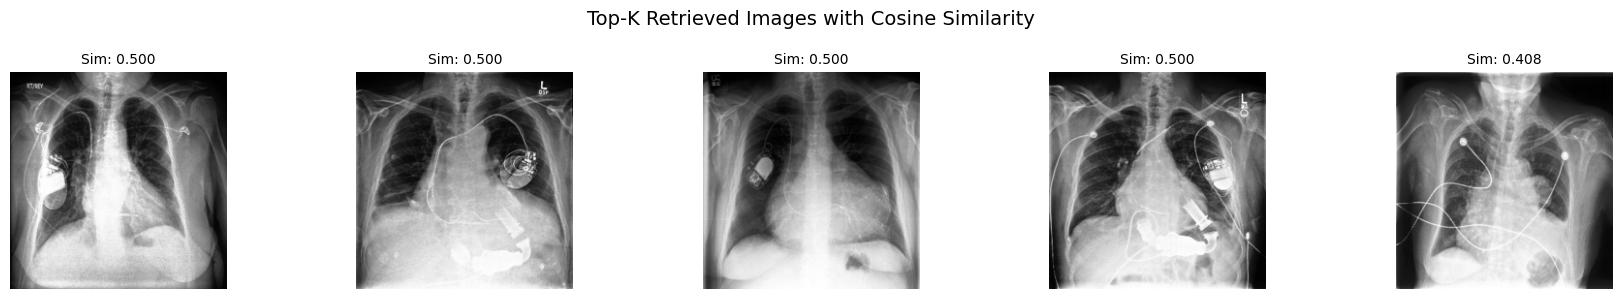

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

output_path = BASE_DIR / "resnet_model/label_to_image_inference_results.csv"

import matplotlib.pyplot as plt
from PIL import Image

def visualize_top_k_images_with_scores(query_labels, image_df, k=5, image_root=IMAGE_ROOT):
    image_vectors = image_df[[f"pred_{label}" for label in LABELS]].values
    sims = cosine_similarity([query_labels], image_vectors)[0]
    top_k_indices = sims.argsort()[::-1][:k]

    fig, axs = plt.subplots(1, k, figsize=(3.5 * k, 3))
    fig.suptitle("Top-K Retrieved Images with Cosine Similarity", fontsize=14)

    for i, idx in enumerate(top_k_indices):
        row = image_df.iloc[idx]
        full_path = image_root / row["split"] / "images" / row["filename"]

        image = Image.open(full_path).convert("RGB")
        axs[i].imshow(image)
        axs[i].axis("off")
        axs[i].set_title(f"Sim: {sims[idx]:.3f}", fontsize=10)

    plt.tight_layout()
    plt.show()

def retrieve_top_k_images_with_scores(query_labels, image_df, k=5):
    image_vectors = image_df[[f"pred_{label}" for label in LABELS]].values
    sims = cosine_similarity([query_labels], image_vectors)[0]
    top_k_indices = sims.argsort()[::-1][:k]

    results = image_df.iloc[top_k_indices].copy()
    results["cosine_score"] = sims[top_k_indices]
    return results[["path_to_image", "cosine_score"] + [f"pred_{lbl}" for lbl in LABELS]]


query = np.array([0, 1, 0, 1] + [0] * 10)  # Cardiomegaly + Edema

# Table view
top_df = retrieve_top_k_images_with_scores(query, df_preds, k=5)
display(top_df)

# Image view
visualize_top_k_images_with_scores(query, df_preds, k=5)

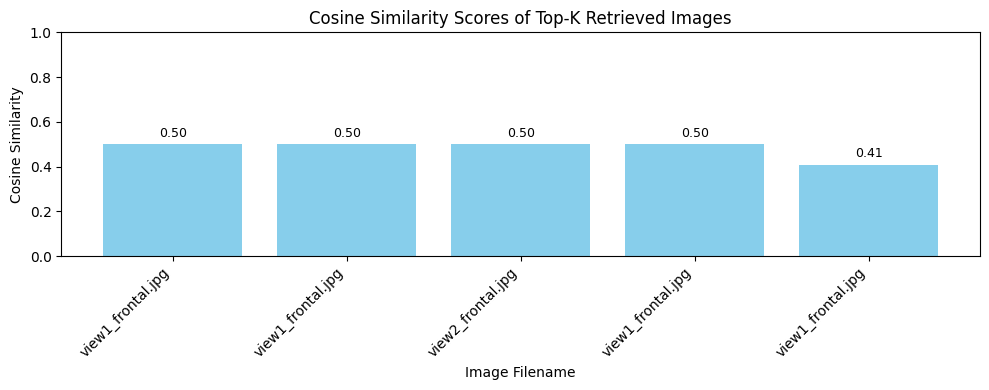

In [ ]:
import matplotlib.pyplot as plt

def plot_similarity_scores(query_labels, image_df, k=5):
    image_vectors = image_df[[f"pred_{label}" for label in LABELS]].values
    sims = cosine_similarity([query_labels], image_vectors)[0]
    top_k_indices = sims.argsort()[::-1][:k]

    top_scores = sims[top_k_indices]
    top_paths = image_df.iloc[top_k_indices]["path_to_image"].apply(lambda x: Path(x).name)

    plt.figure(figsize=(10, 4))
    bars = plt.bar(range(k), top_scores, tick_label=top_paths, color='skyblue')
    plt.ylim(0, 1)
    plt.title("Cosine Similarity Scores of Top-K Retrieved Images")
    plt.xlabel("Image Filename")
    plt.ylabel("Cosine Similarity")
    plt.xticks(rotation=45, ha='right')

    # Add score labels on top
    for bar, score in zip(bars, top_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                 f"{score:.2f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

query = np.array([0, 1, 0, 1] + [0] * 10)  # Cardiomegaly + Edema
df_preds = pd.read_csv(output_path)

plot_similarity_scores(query, df_preds, k=5)